<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"><a href="https://www.editorialuoc.cat/deep-learning" target="_blank\">Deep learning: Principios y fundamentos</a></p>
<p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Universitat Oberta de Catalunya (UOC)</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Capítulo 10: Ejemplo de análisis de series temporales (TSA) empleando redes neuronales recurrentes (RNN) con Keras


En este ejemplo trabajaremos con redes neuronales recurrentes en un problema de regresión con datos generados sintéticamente, a partir de la librería `Keras`.

Al inicio del ejemplo veremos como generar datos de forma sintética para una serie temporal. A continuación, trataremos de eliminar tendencias y estacionalidades para preparar los datos y, finalmente, con los datos normalizados, entrenaremos varios modelos que permitirán predecir los valores futuros de la serie.

# 1. Carga de las librerías

El siguiente código carga los paquetes necesarios para este ejemplo.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from stldecompose import decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 2. Generación de los datos sintéticos

En este ejemplo trabajaremos con una serie temporal generada sintéticamente utilizando `numpy`. 

El siguiente código genera una serie temporal con cierta aleatoriedad, guarda la serie en la variable `serie` y la visualiza en una gráfica.

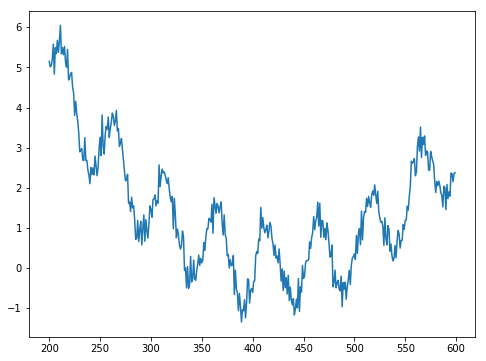

In [2]:
# función para generar los datos de la serie
def f(x):
    return np.square(-x+425)/10000 + np.sin(x/8) + 0.25*np.random.randn()

# datos de la serie
idx = np.arange(200, 600)
serie = [f(x) for x in idx]

# visualización de la serie
plt.rc("figure", figsize=(8,6))
plt.plot(idx, serie)
plt.show()

# 3. Eliminar la tendencia y estacionalidad

Para que la red neuronal pueda extraer patrones de la serie temporal es necesario transformar la serie para que los valores estén siempre en el mismo rango. Para ello, podemos extraer la **tendencia** y la **estacionalidad** de la serie y deshacer el cambio en el momento de obtener predicciones.

En este caso de ejemplo, al haber generado los datos de forma sintética, podemos calcular la periodicidad exacta a través de la fórmula de generación de datos. Dado que el seno es una función periódica de periodo $2*\pi$, el periodo de la serie será aquel valor de $x$ tal que $x$ / 8 = $2*\pi$, que redondeado a un número entero es 50.

A continuación, procederemos a extraer la tendencia y la estacionalidad de forma empírica utilizando la función `decompose` del paquete `stldecompose` y dibujarla con el método `plot` de la misma librería.

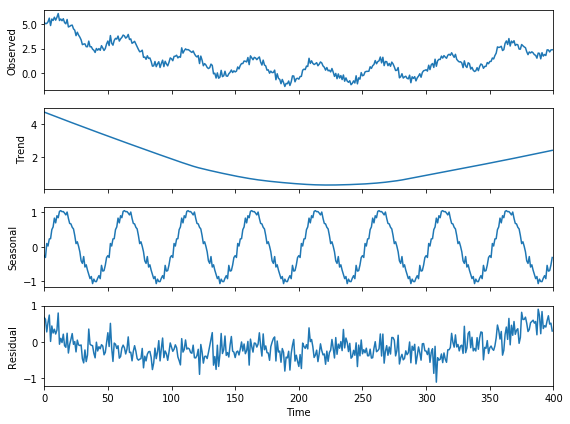

In [3]:
# descomposición de la serie
decomp = decompose(serie, period=50)
decomp.plot()
plt.show()

A continuación, procederemos a repetir la extracción de tendencia y estacionalidad utilizando diferentes valores para el periodo, con el fin de ver la relevancia de determinar el período en la extracción de la tendencia y la estacionalidad. Probaremos con valores múltiplos y divisores del periodo, así como con otros valores al azar.

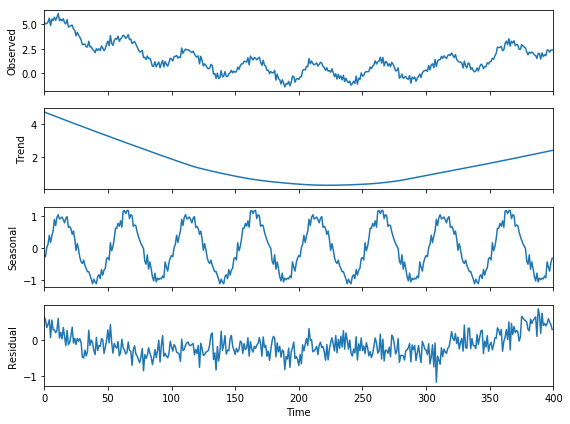

In [4]:
# descomposición de la serie
decomp_100 = decompose(serie, period=100)
decomp_100.plot()
plt.show()

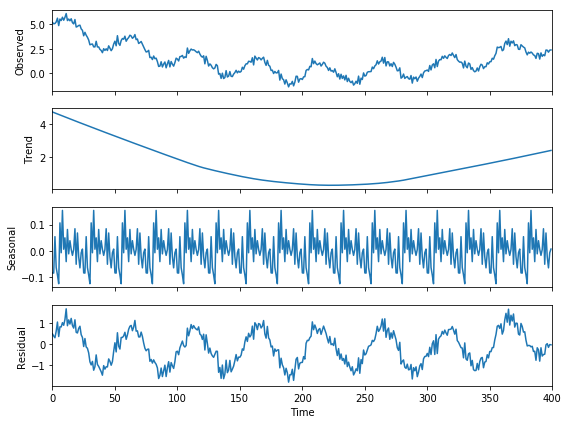

In [5]:
# descomposición de la serie
decomp_25 = decompose(serie, period=25)
decomp_25.plot()
plt.show()

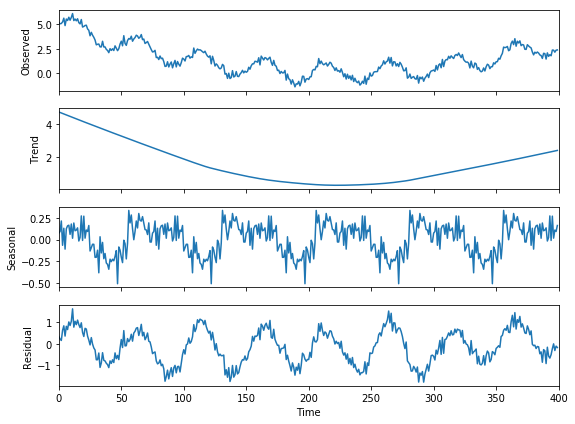

In [6]:
# descomposición de la serie
decomp_75 = decompose(serie, period=75)
decomp_75.plot()
plt.show()

A partir de los ejemplos anteriores y la importancia de calcular correctamente el periodo estacional de una serie temporal, podemos determinar que:

- Si se utiliza un **múltiplo del periodo correcto** la descomposición se hace bien.
- Si se utilizan **otros valores** la descomposición pierde completamente el sentido.

Existen muchos otros métodos para eliminar la tendendica y estacionalidad de una serie.

Una posibilidad consiste en transformar la serie haciendo $y[t] = x[t] - x[t-1]$. En este caso, las principales diferencias con el ejemplo visto son:

- Se puede utilizar en cualquier caso y no hace falta averiguar el periodo de estacionalidad.
- Se pierde la "memoria" de la red, ya que el valor $y[t]$ solo depende de los valores de la serie en $t-1$ y $t$.

# 4. Predicción de la tendencia

La tendencia de una serie temporal cambia lentamente con el tiempo. Además, en el momento de realizar predicciones normalmente toma valores fuera del rango que aparece en los datos de entrenamiento. Esto fuerza al modelo a extrapolar, por lo que hay que utilizar modelos muy robustos para predecir la tendencia.

En primer lugar, entrenaremos un modelo polinomial con las variables $x$ y $x^2$ para predecir los valores de la tendencia en el conjunto de entrenamiento, empleando la librería `LinearRegression`.

In [7]:
# Preparación de los datos y entrenamiento del modelo
features = np.hstack([idx.reshape(-1, 1), np.square(idx.reshape(-1, 1))])
reg = LinearRegression().fit(features, decomp.trend)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


En el siguiente fragmento de código crearemos una gráfica con la tendencia original y su predicción.

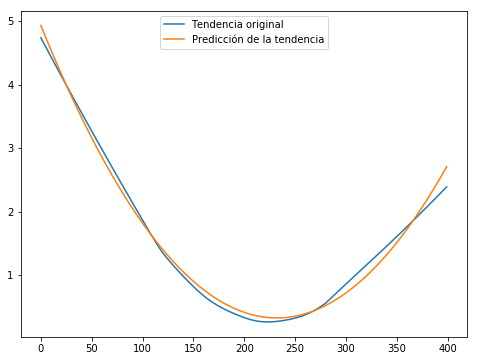

In [8]:
# Visualización de la tendencia original y la predicción
plt.rc("figure", figsize=(8,6))
plt.plot(decomp.trend, label="Tendencia original")
plt.plot(reg.predict(features), label="Predicción de la tendencia")
plt.legend(loc="upper center")
plt.show()

# 5. Predicción de la parte estacionaria

Al descomponer la serie temporal obtenemos la estacionalidad como una nueva serie temporal que se repite cada cierto tiempo, por lo que es muy adecuada para predecirla utilizando una red neuronal recurrente (RNN). 

Dado que las redes neuronales repiten varias veces la misma operación sobre un conjunto de datos, es importante normalizar los valores para evitar problemas de explosión o desaparición del gradiente.

El siguiente fragmento de código indica como normalizar los valores de la serie estacionaria a valores entre 0 y 1.

In [9]:
# Normalización de los datos
scaler = MinMaxScaler(feature_range = (0, 1))
scaler_season = scaler.fit(decomp.seasonal.reshape(-1, 1))
seasonal_norm = scaler_season.transform(decomp.seasonal.reshape(-1, 1))

El siguiente código genera el *dataset* de entrenamiento de la red recurrente. Utilizando `lookback = 30` cada ejemplo del *dataset* contiene los 30 últimos valores de la serie y su etiqueta corresponde al siguiente valor.

In [10]:
# Generación del dataset de entrenamiento para la RNN
lookback = 30

features_set = [] 
labels = []  
for i in range(lookback, seasonal_norm.shape[0]):  
    features_set.append(seasonal_norm[i-lookback:i, 0])
    labels.append(seasonal_norm[i, 0])

features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

A continuación, procederemos a definir y entrenar una red neuronal recurrente (RNN) con las siguientes características:

- Una capa recurrente con **celdas GRU** 
- Una capa **completamente conectada (FCC)** de una única neurona, con función de **activación lineal**.

In [11]:
# Creación del modelo de RNN
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(units=50, input_shape=(features_set.shape[1], 1)))
model.add(tf.keras.layers.Dense(units = 1))
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [12]:
# Entrenamiento del modelo
history = model.fit(features_set, labels, epochs = 25, batch_size = 32, validation_split=0.1)

Train on 333 samples, validate on 37 samples
Epoch 1/25
333/333 [==============================] - 1s 2ms/step - loss: 0.1944 - val_loss: 0.0479
Epoch 2/25
333/333 [==============================] - 0s 678us/step - loss: 0.0372 - val_loss: 0.0395
Epoch 3/25
333/333 [==============================] - 0s 708us/step - loss: 0.0323 - val_loss: 0.0279
Epoch 4/25
333/333 [==============================] - 0s 685us/step - loss: 0.0213 - val_loss: 0.0159
Epoch 5/25
333/333 [==============================] - 0s 704us/step - loss: 0.0197 - val_loss: 0.0140
Epoch 6/25
333/333 [==============================] - 0s 915us/step - loss: 0.0164 - val_loss: 0.0142
Epoch 7/25
333/333 [==============================] - 0s 777us/step - loss: 0.0141 - val_loss: 0.0113
Epoch 8/25
333/333 [==============================] - 0s 851us/step - loss: 0.0123 - val_loss: 0.0092
Epoch 9/25
333/333 [==============================] - 0s 921us/step - loss: 0.0106 - val_loss: 0.0083
Epoch 10/25
333/333 [==================

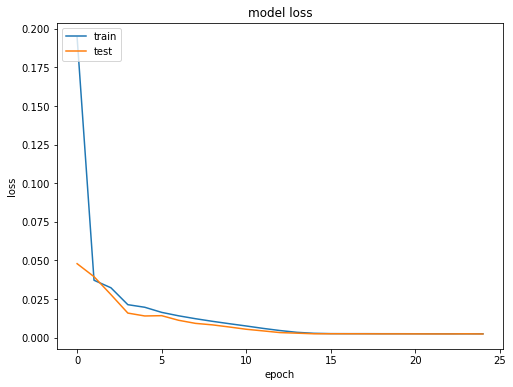

In [13]:
# Visualizamos la evolución de 'loss'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

A continuación, vamos a utilizar el modelo entrenado anteriormente para predecir los valores del conjunto de entrenamiento de la serie estacionaria.

In [14]:
# predicción de los datos
train_pred = model.predict(features_set)

Y dibujaremos una gráfica con la tendencia original y su predicción.

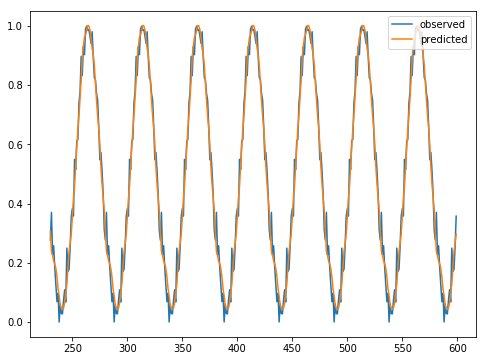

In [15]:
# Gráfico de la tendencia original y su predicción
plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], seasonal_norm[lookback:], label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted")
plt.legend(loc="upper right")
plt.show()

# 6. Predicción completa de la serie

Para predecir nuevos valores de la serie original es necesario realizar predicciones con los dos modelos, deshacer la normalización de la red neuronal y sumar las dos predicciones.

El siguiente código nos muestra cómo calcular la predicción agregada de la serie original y dibujar en una gráfica las predicciones junto a los valores de la serie original.

In [16]:
# Predicción de la serie temporal
train_pred = np.add(scaler_season.inverse_transform(train_pred).reshape(-1), reg.predict(features[lookback:]))

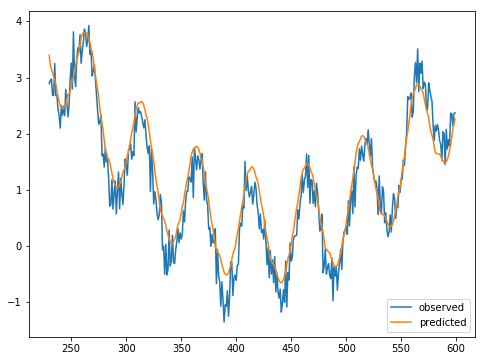

In [17]:
# Gráfica de los valores observados y predicción
plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], serie[lookback:], label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted")
plt.legend(loc="lower right")
plt.show()

# 7. Predicción de valores futuros

A continuación generaremos nuevos valores de la serie sintética para comprobar el rendimiento de las predicciones.

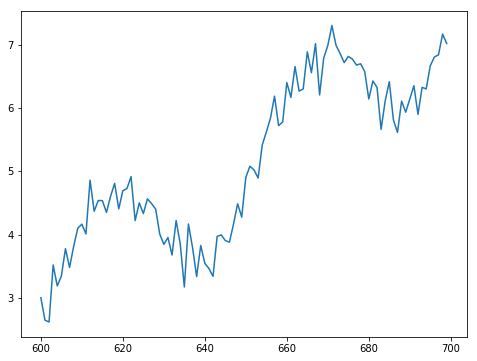

In [18]:
# generamos nuevos valores de la serie
idx_new = np.arange(600, 700)
serie_new = [f(x) for x in idx_new]

plt.rc("figure", figsize=(8,6))
plt.plot(idx_new, serie_new)
plt.show()

Utilizaremos el modelo polinomial entrenado anteriormente para calcular la predicción de la tendencia en los nuevos valores de la serie.

In [19]:
# Predicción de la tendencia
features_new = np.hstack([idx_new.reshape(-1, 1), np.square(idx_new.reshape(-1, 1))])
pred_tendencia = reg.predict(features_new)

El siguiente código predice valores de la serie estacionaria uno a uno y utiliza los valores predichos como entrada para predecir los siguientes valores de la serie.

In [20]:
pre_data = seasonal_norm[-lookback:]
reg_orig = np.array(pre_data)

test_preds = []
for i in idx_new:
    reg_lstm = np.reshape(reg_orig, (1, reg_orig.shape[0], 1))
    test_pred = model.predict(reg_lstm)
    test_preds.append(test_pred)
    reg_orig = np.roll(reg_orig, -1)
    reg_orig[-1] = test_pred

test_preds = np.array(test_preds).reshape(-1, 1)

Finalmente, podemos agregar las predicciones de los dos modelos para los nuevos valores y mostrar toda la información en una única gráfica.

In [21]:
test_pred = np.add(scaler_season.inverse_transform(test_preds).reshape(-1), pred_tendencia)

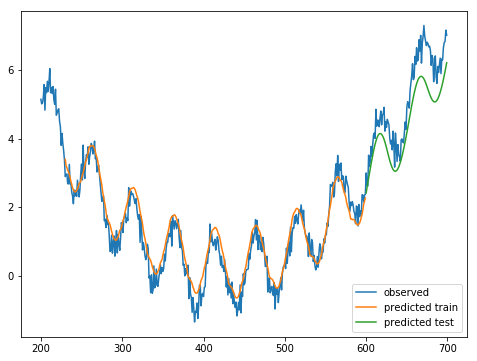

In [22]:
idx_global = np.arange(200, 700)
obs = np.hstack([serie, serie_new])

plt.rc("figure", figsize=(8,6))
plt.plot(idx_global, obs, label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted train")
plt.plot(idx_new, test_pred, label="predicted test")
plt.legend(loc="lower right")
plt.show()